In [32]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (20,5)
plt.rcParams['figure.dpi'] = 250
sns.set_style('darkgrid')
%matplotlib inline
from sklearn.metrics import mean_absolute_error

In [2]:
df = pd.read_csv('exchange_rate.csv')
df

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


## The dataset is about datewise exchange rate of USD to AUD ##

In [3]:
df.dtypes

date        object
Ex_rate    float64
dtype: object

<Axes: >

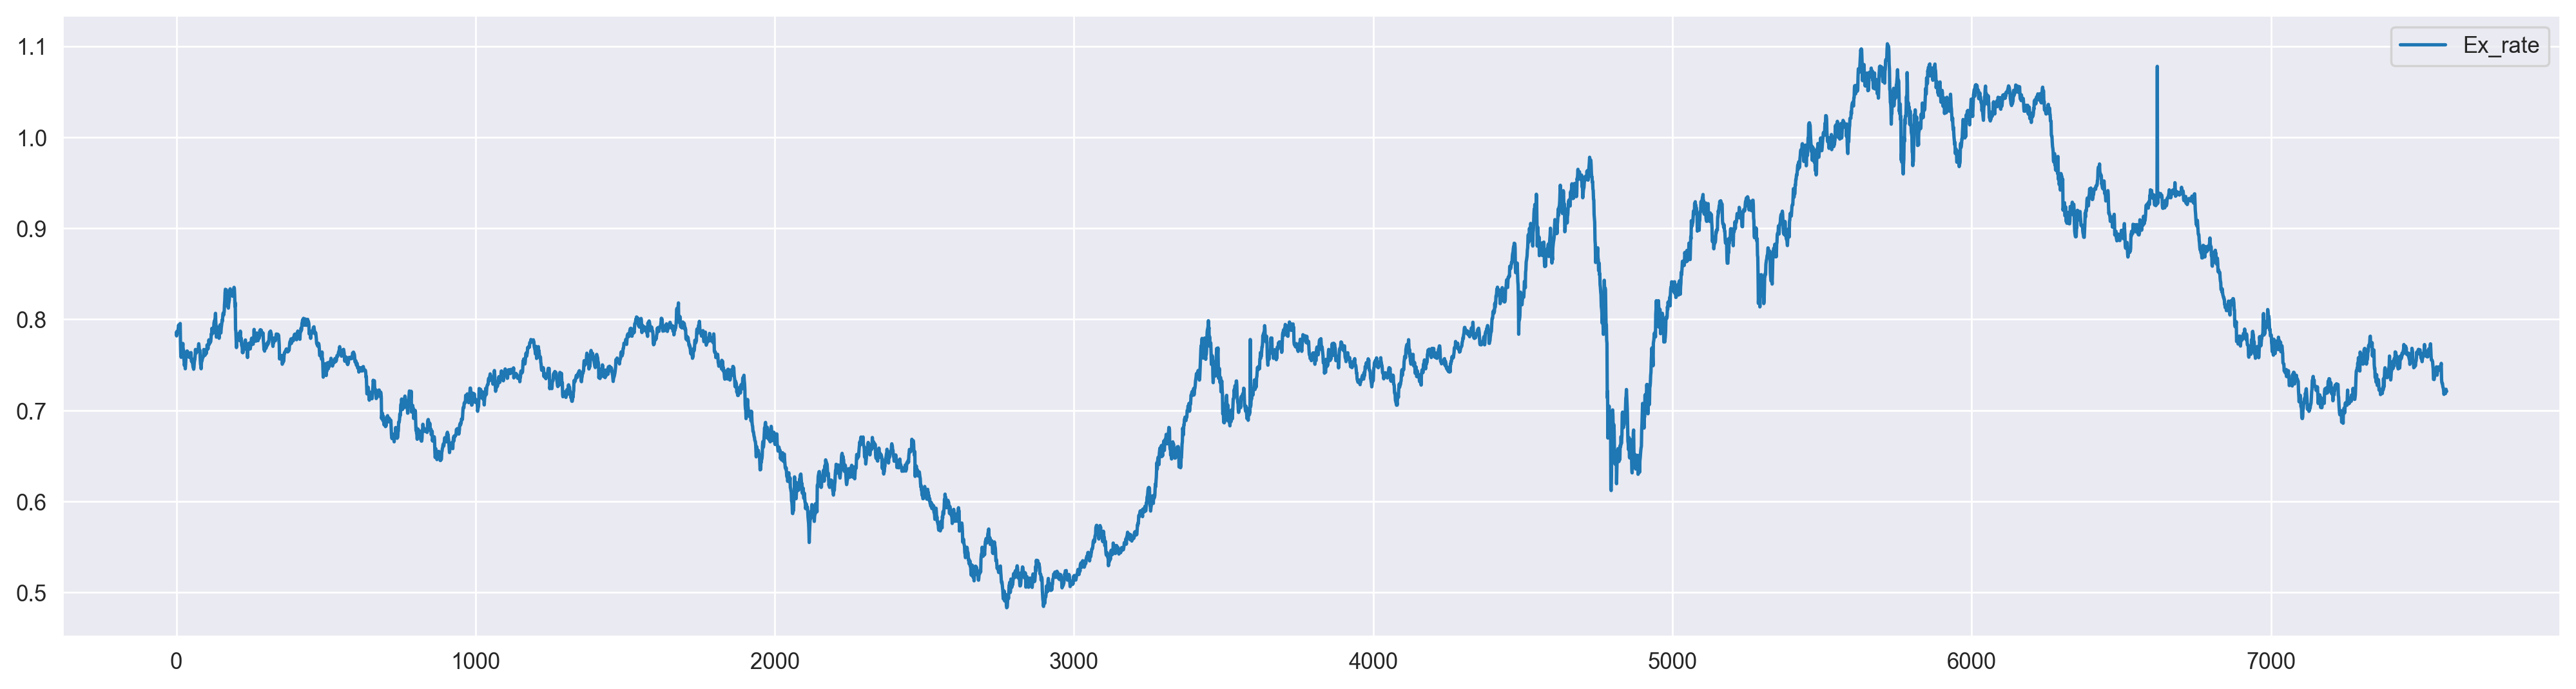

In [4]:
df.plot()

# finding out order of arima ##

In [5]:
adfuller(df['Ex_rate'])[1]

0.44923273535982894

In [6]:
order = auto_arima(df['Ex_rate'])

In [7]:
order

ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [25]:
result = adfuller(df['Ex_rate'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

# Interpretation:
if result[1] < 0.05:
    print("The data is stationary (reject the null hypothesis).")
else:
    print("The data is non-stationary (fail to reject the null hypothesis).")

ADF Statistic: -1.664994180738078
p-value: 0.44923273535982894
Critical Values: {'1%': -3.4312123140180137, '5%': -2.861921078147796, '10%': -2.5669728434336108}
The data is non-stationary (fail to reject the null hypothesis).


##  from the above step we can see that the data is non stationary ##

In [8]:
df.shape

(7588, 2)

In [9]:
#Split the data
train = df.iloc[:-30]
test = df.iloc[-30:]

## converting the date column in to datetime format ##

In [10]:

# Convert 'date' to datetime and ensure 'Ex_rate' is numeric
test['date'] = pd.to_datetime(test['date'], format='%d-%m-%Y %H:%M')
test['Ex_rate'] = pd.to_numeric(test['Ex_rate'])

# Assuming ypred contains predicted values and test['Ex_rate'] contains actual values
actual = test['Ex_rate']


In [11]:
train.shape

(7558, 2)

## Model Building ##

In [12]:
model = ARIMA(train['Ex_rate'], order=(1, 1, 0)).fit()

In [13]:
ypred = model.predict(start =7588, end = 7617)

In [14]:
print(np.sqrt(mean_squared_error(test['Ex_rate'], ypred)))

0.016634527783604417


## Since the RMSE is fairly small (depending on the range of your exchange rate values), it suggests that the model performs reasonably well.##

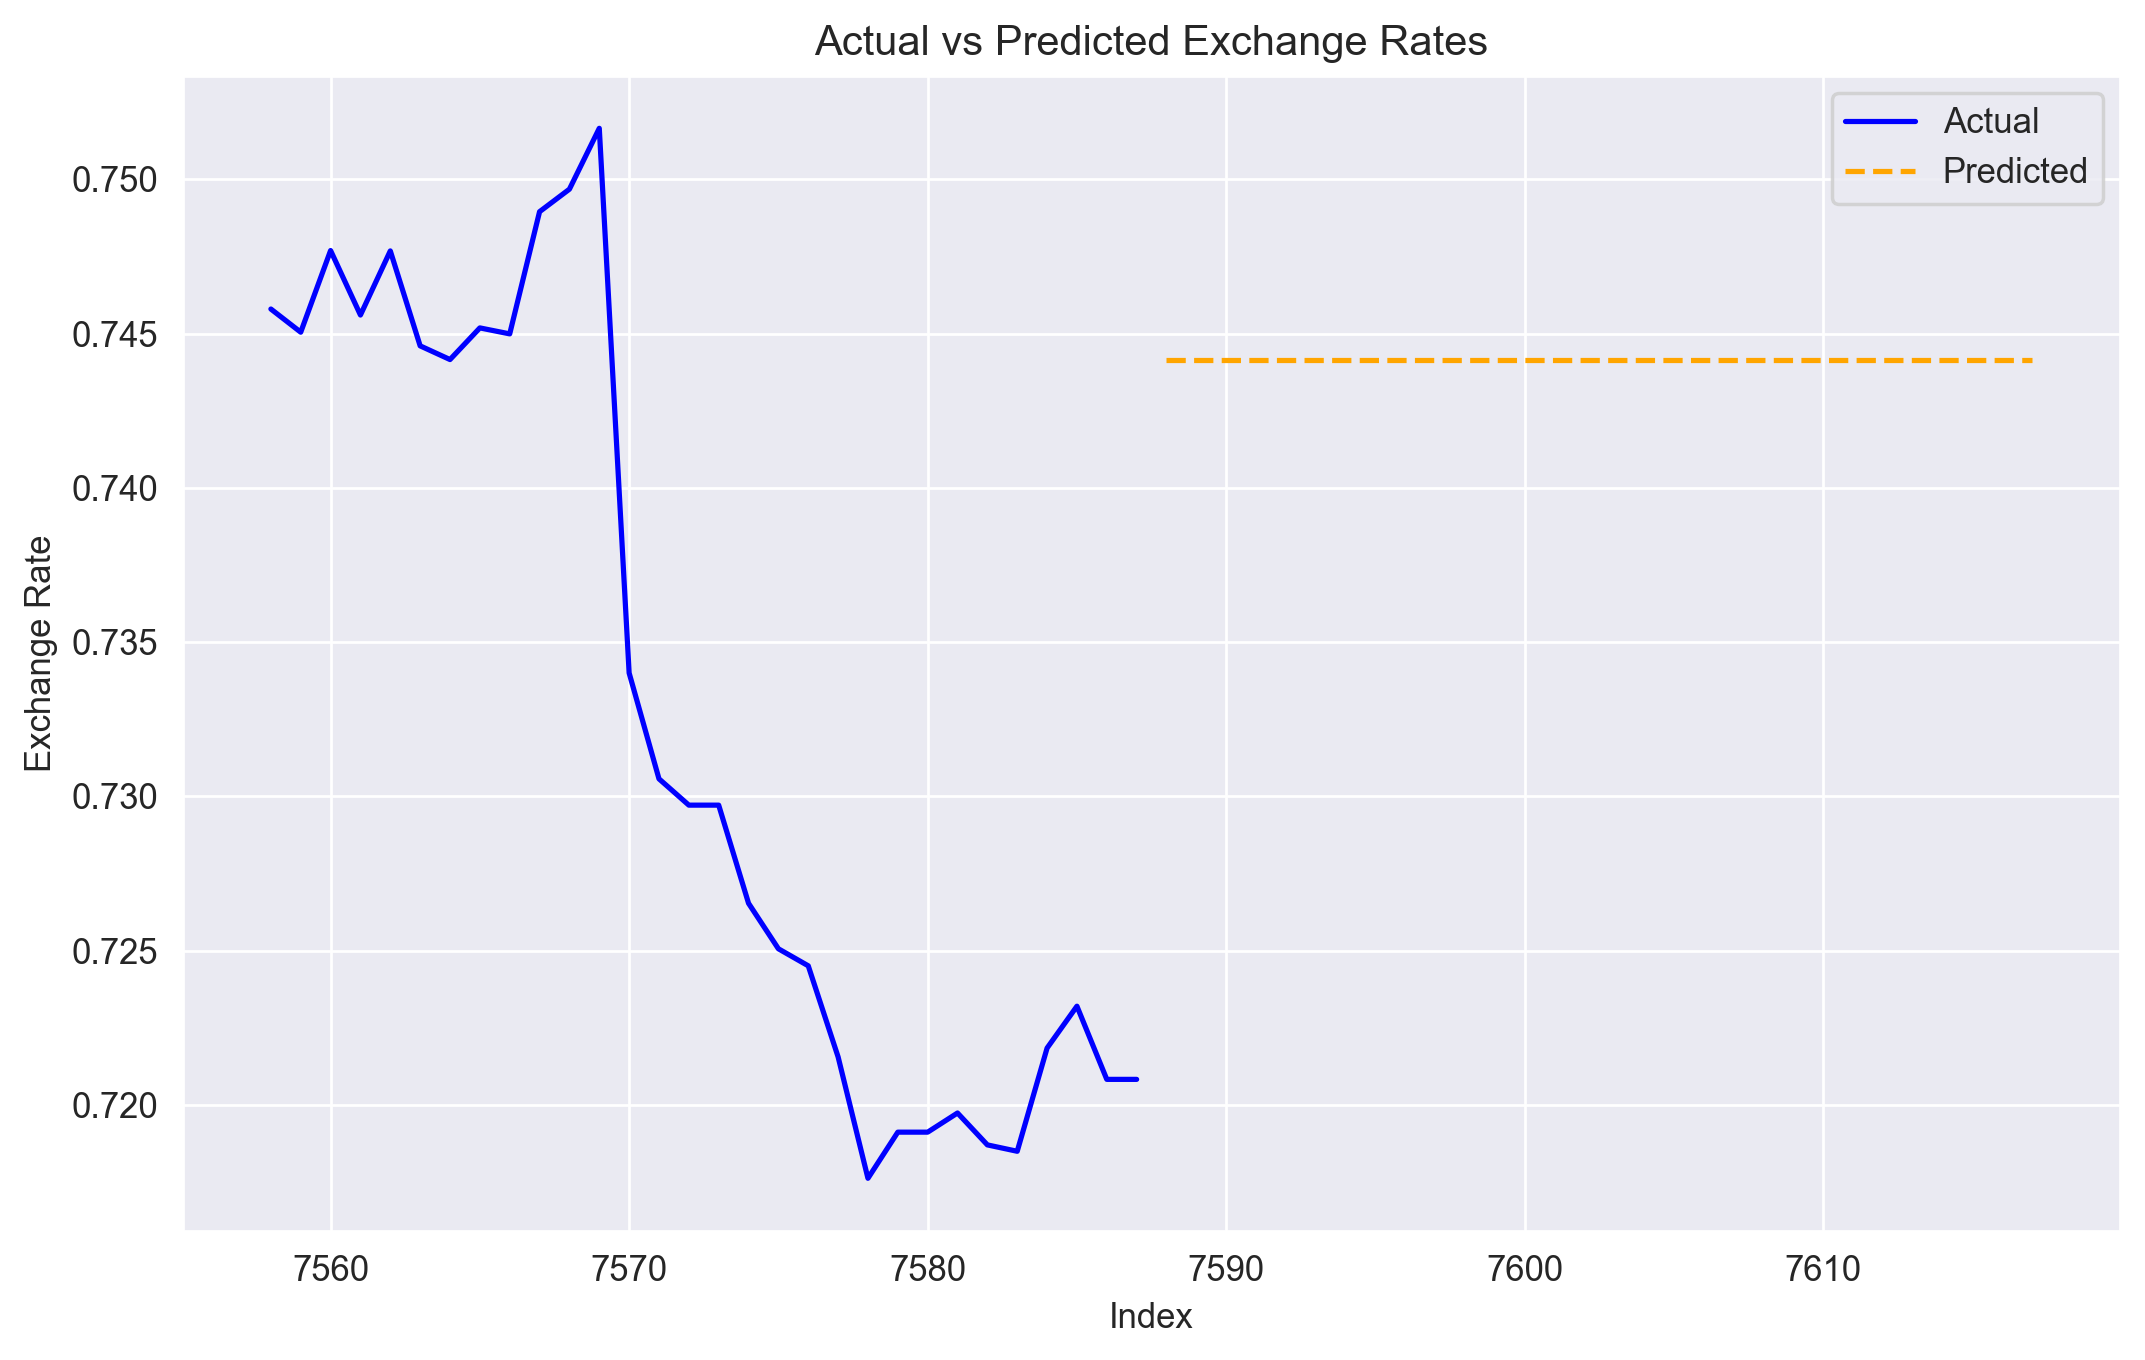

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(test['Ex_rate'], label='Actual', color='blue')
plt.plot(ypred, label='Predicted', color='orange', linestyle='--')
plt.title('Actual vs Predicted Exchange Rates')
plt.xlabel('Index')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

<Figure size 2500x1250 with 0 Axes>

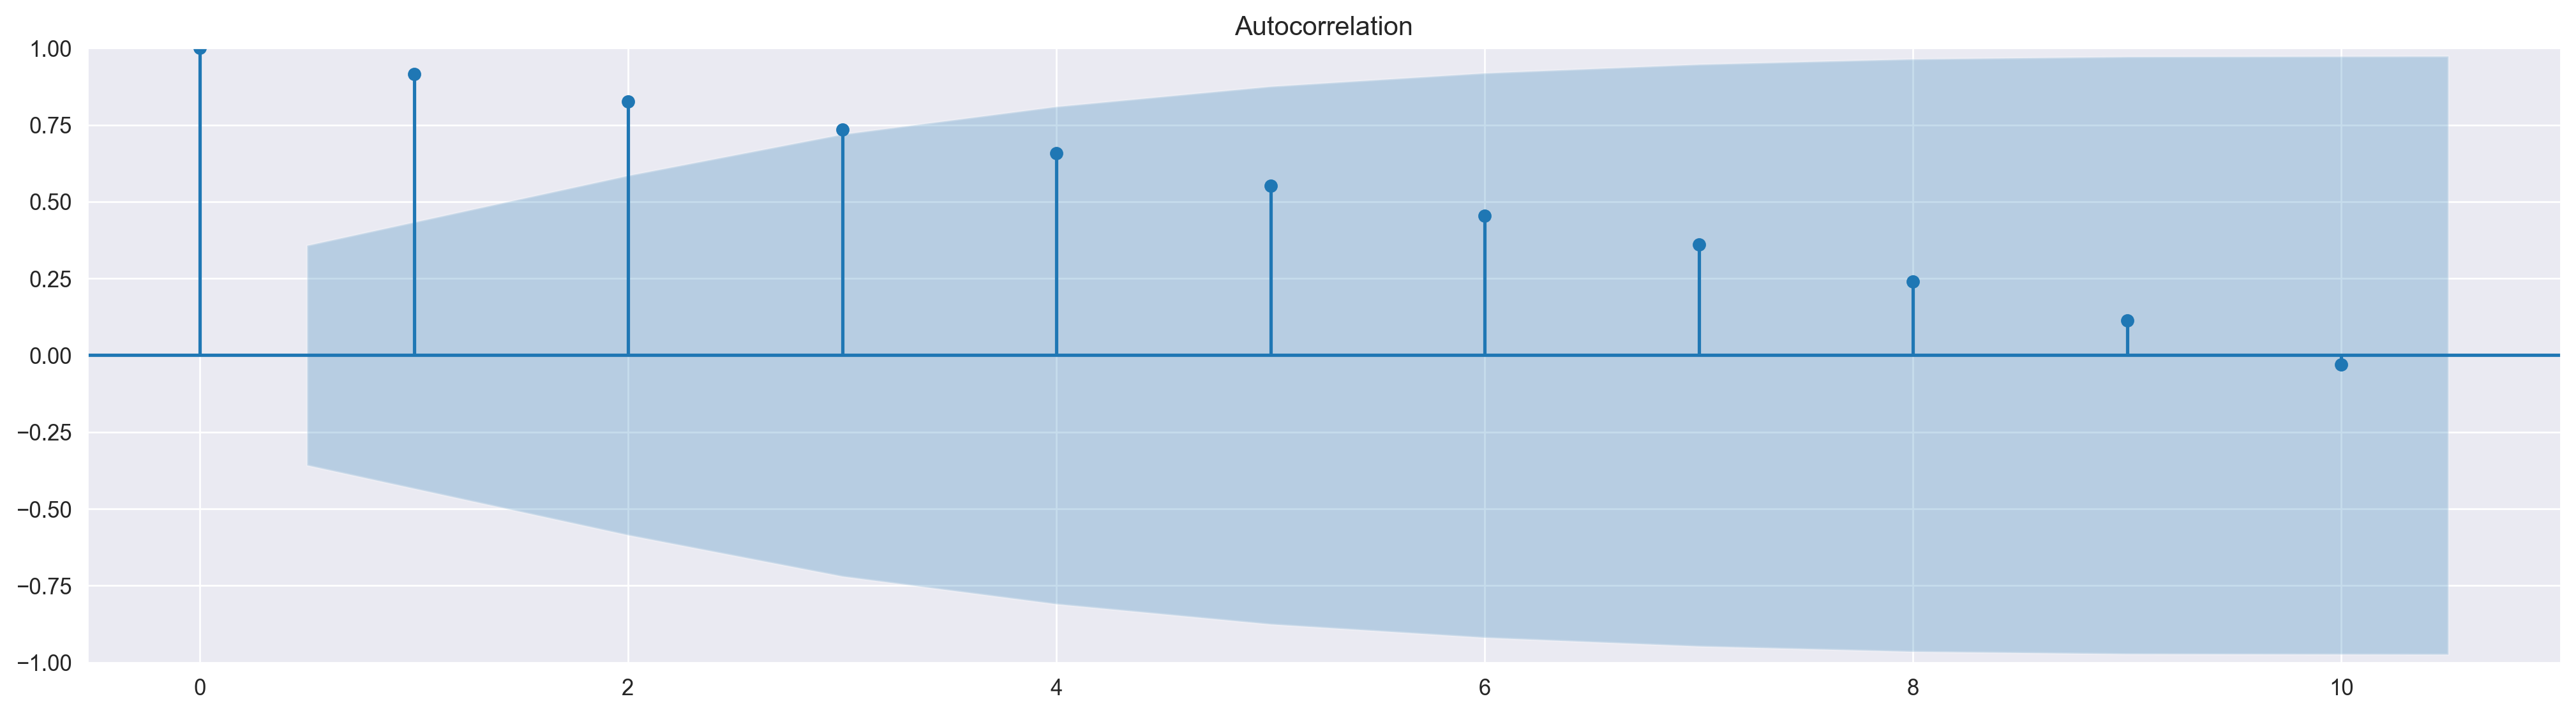

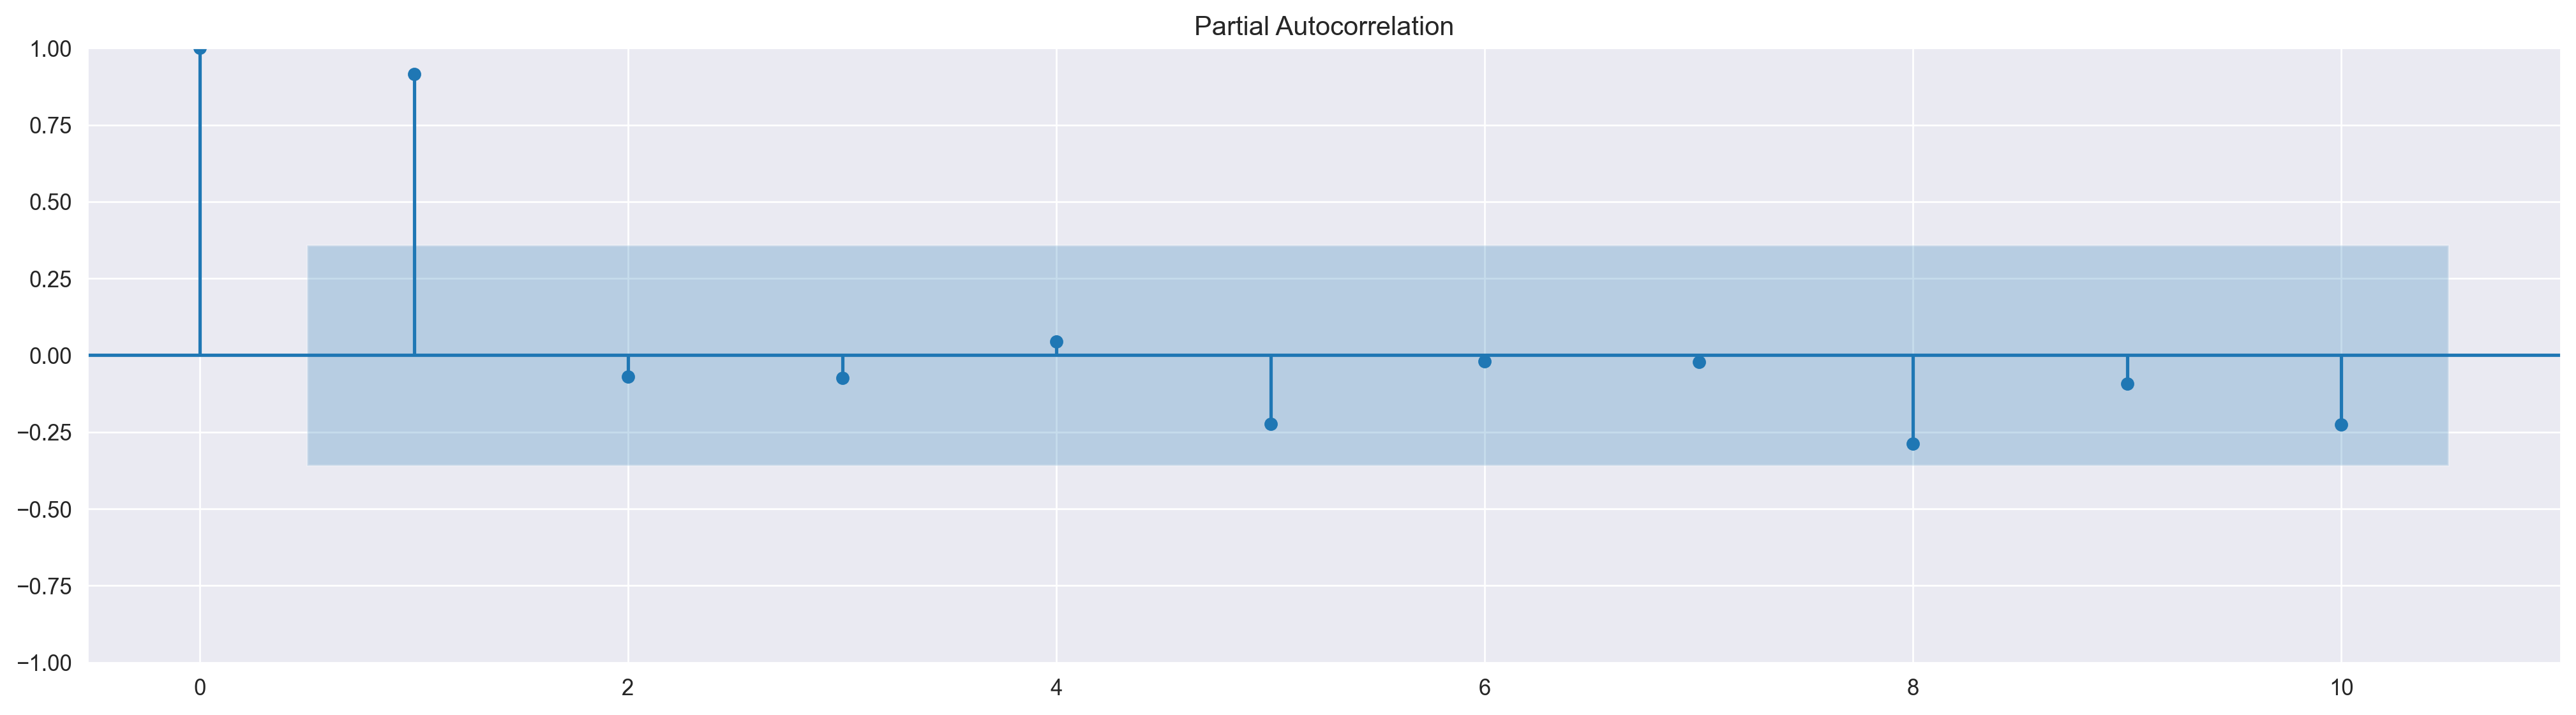

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load your time series data
data = test['Ex_rate']  # Assuming 'test' has been preprocessed

# Plot ACF and PACF
plt.figure(figsize=(10, 5))
plot_acf(data, lags=10, title="Autocorrelation")
plot_pacf(data, lags=10, title="Partial Autocorrelation")
plt.show()


In [16]:
# Fit ARIMA model
p, d, q = 1, 1, 0
model = ARIMA(data, order=(p, d, q))  # Replace with your chosen (p, d, q)
model_fit = model.fit()



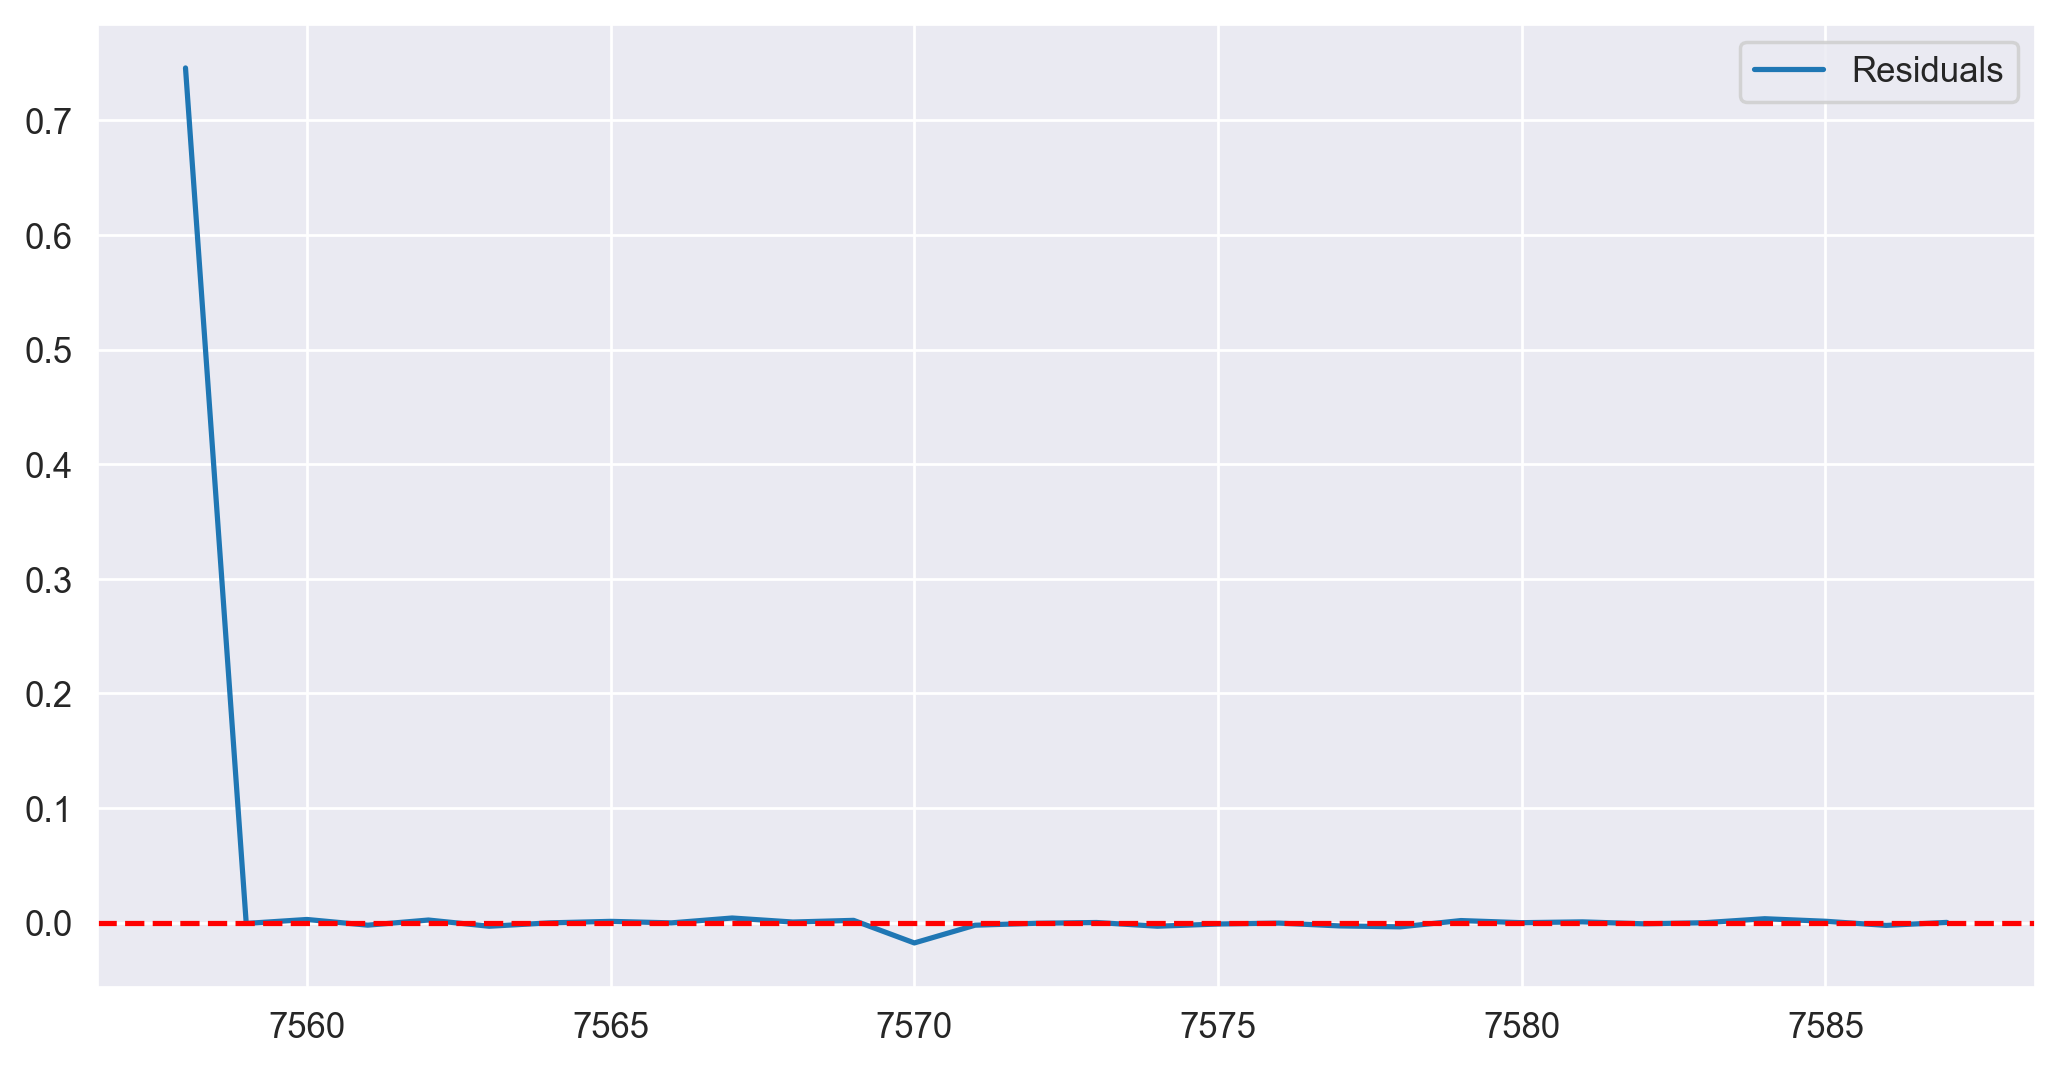

count    30.000000
mean      0.024081
std       0.136362
min      -0.017782
25%      -0.002014
50%      -0.000193
75%       0.001120
max       0.745796
dtype: float64


In [17]:
# Plot residuals
residuals = model_fit.resid
plt.figure(figsize=(10, 5))
plt.plot(residuals, label="Residuals")
plt.axhline(y=0, color='r', linestyle='--')
plt.legend()
plt.show()

# Check residual statistics
print(residuals.describe())


7588    0.720825
7589    0.720825
7590    0.720825
7591    0.720825
7592    0.720825
7593    0.720825
7594    0.720825
7595    0.720825
7596    0.720825
7597    0.720825
7598    0.720825
7599    0.720825
7600    0.720825
7601    0.720825
7602    0.720825
7603    0.720825
7604    0.720825
7605    0.720825
7606    0.720825
7607    0.720825
7608    0.720825
7609    0.720825
7610    0.720825
7611    0.720825
7612    0.720825
7613    0.720825
7614    0.720825
7615    0.720825
7616    0.720825
7617    0.720825
Name: predicted_mean, dtype: float64


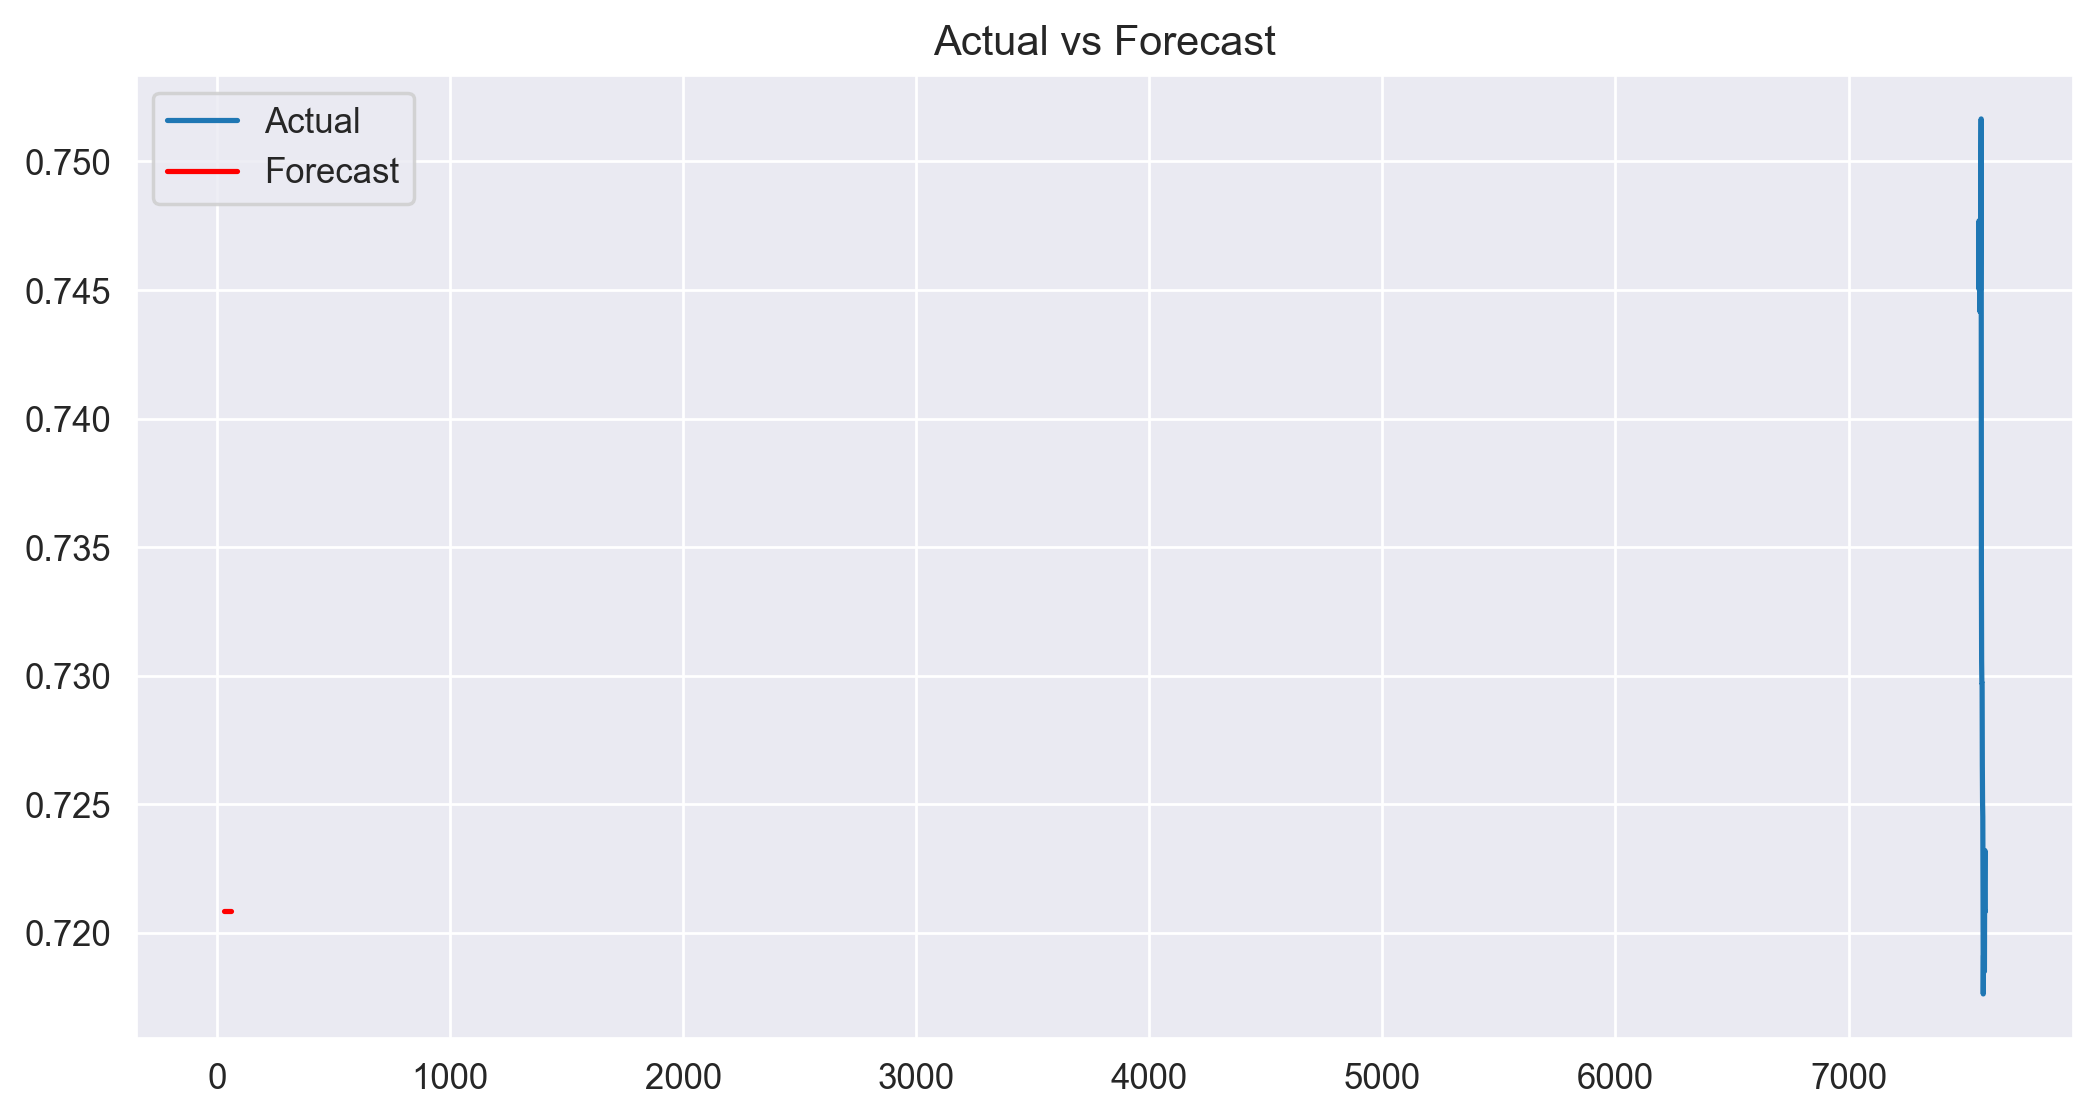

In [18]:
# Out-of-sample forecast
forecast_steps = 30  # Predict for the next 30 days
forecast = model_fit.forecast(steps=forecast_steps)
print(forecast)

# Visualize predictions
plt.figure(figsize=(10, 5))
plt.plot(data, label="Actual")
plt.plot(range(len(data), len(data) + forecast_steps), forecast, label="Forecast", color='red')
plt.legend()
plt.title("Actual vs Forecast")
plt.show()


In [19]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Example grid search for seasonal Holt-Winters model
best_aic = float('inf')
best_params = None
for trend in ['add', 'mul', None]:
    for seasonal in ['add', 'mul', None]:
        try:
            model = ExponentialSmoothing(df['Ex_rate'], trend=trend, seasonal=seasonal, seasonal_periods=12)
            fitted_model = model.fit()
            if fitted_model.aic < best_aic:
                best_aic = fitted_model.aic
                best_params = (trend, seasonal)
        except:
            continue

print(f"Best AIC: {best_aic}")
print(f"Best Parameters: {best_params}")


Best AIC: -77644.98075021675
Best Parameters: (None, None)


## As per above results there is no No Trend or Seasonality ##
## Low AIC Value: AIC of -77644.98 indicates a good model fit. ##

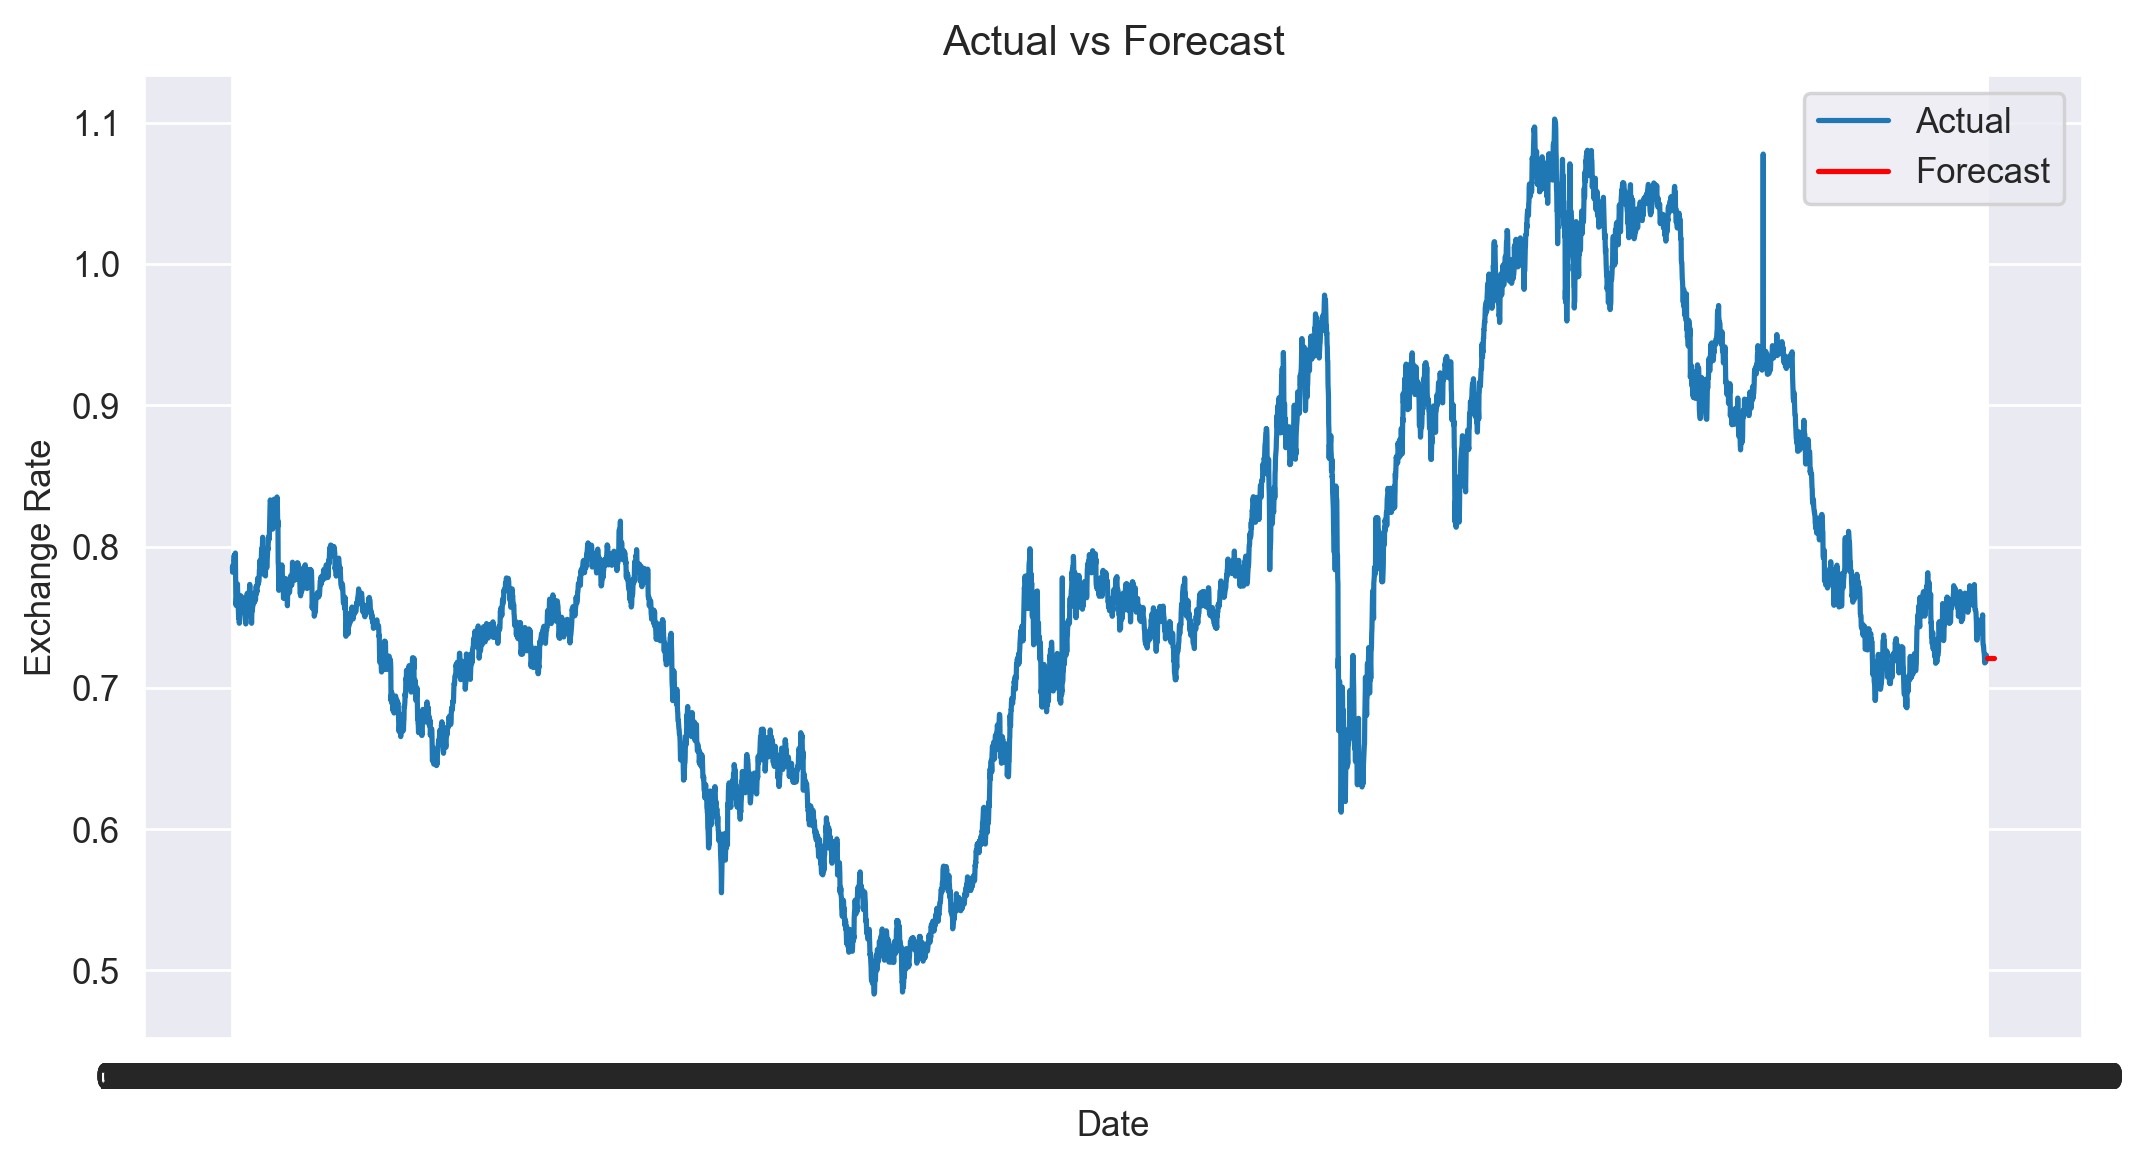

In [38]:
best_trend, best_seasonal = best_params
final_model = ExponentialSmoothing(
    df['Ex_rate'], 
    trend=best_trend, 
    seasonal=best_seasonal, 
    seasonal_periods=12
).fit()

# Forecast future values
forecast_steps = 30
forecast = final_model.forecast(steps=forecast_steps)

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['Ex_rate'], label="Actual")
plt.plot(
    range(len(df), len(df) + forecast_steps), forecast, 
    label="Forecast", color='red'
)
plt.title("Actual vs Forecast")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.show()


## Evaluating the model on mae, rmse. ##

In [50]:
# Assuming test['Ex_rate'] contains actual values and ypred contains predicted values
actual = test['Ex_rate']
predicted = ypred

# Calculate MAE
mae = mean_absolute_error(actual, predicted)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual, predicted))

# Print results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 0.013493833511738473
Root Mean Squared Error (RMSE): 0.016634527783604417
